In [8]:
from torch import nn
import torch
import torch.nn.functional as F


class CNA3d(nn.Module): # conv + norm + activation
    def __init__(self, in_channels, out_channels, kSize, stride, padding=(1,1,1), bias=True, norm_args=None, activation_args:dict=None):
        super().__init__()
        self.norm_args = norm_args
        
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kSize, stride=stride, padding=padding, bias=bias)

        if norm_args is not None:
            self.norm = nn.InstanceNorm3d(out_channels, **norm_args)

        if activation_args is not None:
            self.activation = nn.LeakyReLU(**activation_args)


    def forward(self, x):
        x = self.conv(x)

        if self.norm_args is not None:
            x = self.norm(x)

        if self.activation_args is not None:
            x = self.activation(x)
        return x



class CB3d(nn.Module): # conv block 3d
    def __init__(self, in_channels, out_channels, kSize=(3,3), stride=(1,1), padding=(1,1,1), bias=True,
                 norm_args:tuple=(None,None), activation_args:tuple=(None,None)):
        super().__init__()

        self.conv1 = CNA3d(in_channels, out_channels, kSize=kSize[0], stride=stride[0],
                             padding=padding, bias=bias, norm_args=norm_args[0], activation_args=activation_args[0])

        self.conv2 = CNA3d(out_channels, out_channels,kSize=kSize[1], stride=stride[1],
                             padding=padding, bias=bias, norm_args=norm_args[1], activation_args=activation_args[1])

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x






class BasicNet(nn.Module):
    norm_kwargs = {'affine': True}
    activation_kwargs = {'negative_slope': 1e-2, 'inplace': True}

    def __init__(self):
        super(BasicNet, self).__init__()

    def parameter_count(self):
        print("model has {} parameters in total".format(sum(x.numel() for x in self.parameters()) / 1e6))



In [17]:
from torch import nn


def FMU(x1, x2, mode='sub'):
    """
    feature merging unit
    Args:
        x1:
        x2:
        mode: type of fusion
    Returns:
    """
    if mode == 'sum':
        return torch.add(x1, x2)
    elif mode == 'sub':
        return torch.abs(x1 - x2)
    elif mode == 'cat':
        return torch.cat((x1, x2), dim=1)
    else:
        raise Exception('Unexpected mode')


def dim_convert(inputs):

  zp0 = ZeroPadding3D(padding=(3,3,0))(inputs)
  c3d = Conv3D(16,(7,7,51), activation='relu', kernel_initializer='glorot_uniform')(zp0)
  ac3d = Activation("relu")(c3d)
  bnc3d = BatchNormalization(axis=-1)(ac3d)

  reshp = Reshape((img_w,img_h,16),input_shape=(img_w,img_h,1,16))(bnc3d)

  nd1 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(reshp)
  nd2 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(nd1)
  nd3 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(nd2)

  l11 = Conv2D(16,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(reshp)
  al11 = Activation("relu")(l11)
  bnl11 = BatchNormalization()(al11)

  return bnl11


class Down(BasicNet):
    def __init__(self, in_channels, out_channels, mode: tuple, FMU='sub', downsample=True, min_z=8):
        """
        basic module at downsampling stage
        Args:
            in_channels:
            out_channels:
            mode: represent the streams coming in and out. e.g., ('2d', 'both'): one input stream (2d) and two output streams (2d and 3d)
            FMU: determine the type of feature fusion if there are two input streams
            downsample: determine whether to downsample input features (only the first module of MNet do not downsample)
            min_z: if the size of z-axis < min_z, maxpooling won't be applied along z-axis
        """
        super().__init__()
        self.mode_in, self.mode_out = mode
        self.downsample = downsample
        norm_args = (self.norm_kwargs, self.norm_kwargs)
        activation_args = (self.activation_kwargs, self.activation_kwargs)

        if self.mode_out == '2d' or self.mode_out == 'both':
            self.CB2d = CB3d(in_channels=in_channels, out_channels=out_channels,
                             kSize=((1, 3, 3), (1, 3, 3)), stride=(1, 1), padding=(0, 1, 1),
                             norm_args=norm_args, activation_args=activation_args)

        if self.mode_out == '3d' or self.mode_out == 'both':
            self.CB3d = CB3d(in_channels=in_channels, out_channels=out_channels,
                             kSize=(3, 3), stride=(1, 1), padding=(1, 1, 1),
                             norm_args=norm_args, activation_args=activation_args)

    def forward(self, x):
        if self.downsample:
            if self.mode_in == 'both':
                x2d, x3d = x
                p2d = F.max_pool3d(x2d, kernel_size=(1, 2, 2), stride=(1, 2, 2))
                if x3d.shape[2] >= self.min_z:
                    p3d = F.max_pool3d(x3d, kernel_size=(2, 2, 2), stride=(2, 2, 2))
                elif min_z is None:
                    p3d = dim_convert(x3d)
                else:
                    p3d = F.max_pool3d(x3d, kernel_size=(1, 2, 2), stride=(1, 2, 2))

                x = FMU(p2d, p3d, mode=self.FMU)

            elif self.mode_in == '2d':
                x = F.max_pool3d(x, kernel_size=(1, 2, 2), stride=(1, 2, 2))

            elif self.mode_in == '3d':
                if x.shape[2] >= self.min_z:
                    x = F.max_pool3d(x, kernel_size=(2, 2, 2), stride=(2, 2, 2))
                else:
                    x = F.max_pool3d(x, kernel_size=(1, 2, 2), stride=(1, 2, 2))

        if self.mode_out == '2d':
            return self.CB2d(x)
        elif self.mode_out == '3d':
            return self.CB3d(x)
        elif self.mode_out == 'both':
            return self.CB2d(x), self.CB3d(x)



class Up(BasicNet):
    def __init__(self, in_channels, out_channels, mode: tuple, FMU='sub'):
        """
        basic module at upsampling stage
        Args:
            in_channels:
            out_channels:
            mode: represent the streams coming in and out. e.g., ('2d', 'both'): one input stream (2d) and two output streams (2d and 3d)
            FMU: determine the type of feature fusion if there are two input streams
        """
        super().__init__()
        self.mode_in, self.mode_out = mode
        self.FMU = FMU

        if self.mode_out == '2d' or self.mode_out == 'both':
            self.CB2d = CB3d(in_channels=in_channels, out_channels=out_channels,
                             kSize=((1, 3, 3), (1, 3, 3)), stride=(1, 1), padding=(0, 1, 1),
                             norm_args=norm_args, activation_args=activation_args)

        if self.mode_out == '3d' or self.mode_out == 'both':
            self.CB3d = CB3d(in_channels=in_channels, out_channels=out_channels,
                             kSize=(3, 3), stride=(1, 1), padding=(1, 1, 1),
                             norm_args=norm_args, activation_args=activation_args)

    def forward(self, x):
        x2d, xskip2d, x3d, xskip3d = x

        tarSize = xskip2d.shape[2:]
        up2d = F.interpolate(x2d, size=tarSize, mode='trilinear', align_corners=False)
        up3d = F.interpolate(x3d, size=tarSize, mode='trilinear', align_corners=False)

        cat = torch.cat([FMU(xskip2d, xskip3d, self.FMU), FMU(up2d, up3d, self.FMU)], dim=1)

        if self.mode_out == '2d':
            return self.CB2d(cat)
        elif self.mode_out == '3d':
            return self.CB3d(cat)
        elif self.mode_out == 'both':
            return self.CB2d(cat), self.CB3d(cat)



class ProposedNet(BasicNet):
    def __init__(self, in_channels, num_classes, kn=(32, 48, 64, 80, 96), ds=True, FMU='sub'):
        """

        Args:
            in_channels: channels of input
            num_classes: output classes
            kn: the number of kernels
            ds: deep supervision
            FMU: type of feature merging unit
        """
        super().__init__()
        self.ds = ds
        self.num_classes = num_classes

        channel_factor = {'sum': 1, 'sub': 1, 'cat': 2}
        fct = channel_factor[FMU]

        self.down11 = Down(in_channels, kn[0], ('/', 'both'), downsample=False)
        self.down12 = Down(kn[0], kn[1], ('2d', 'both'))

        self.down21 = Down(kn[0], kn[1], ('3d', 'both'))
        self.down22 = Down(fct * kn[1], kn[2], ('both', 'both'), FMU)
        self.down23 = Down(fct * kn[2], kn[3], ('both', 'both'), FMU)
        self.bottleneck2 = Down(fct * kn[3], kn[4], ('both', 'both'), FMU)

        self.down31 = Down(kn[1], kn[2], ('3d', 'both'))
        self.down32 = Down(fct * kn[2], kn[3], ('both', 'both'), FMU)
        self.bottleneck3 = Down(fct * kn[3], kn[4], ('both', 'both'), FMU)
        self.up31 = Up(fct * (kn[3] + kn[4]), kn[3], ('both', 'both'), FMU)
        self.up32 = Up(fct * (kn[2] + kn[3]), kn[2], ('both', '3d'), FMU)

        self.bottleneck5 = Down(kn[3], kn[4], ('3d', '3d'))

        self.sigmoid = nn.Sigmoid()
        self.outputs = nn.ModuleList(
            [nn.Conv3d(c, num_classes, kernel_size=(1, 1, 1), stride=1, padding=0, bias=False)
             for c in [kn[0], kn[1], kn[1], kn[2], kn[2], kn[3], kn[3]]]
        )

    def forward(self, x):
        down11 = self.down11(x)
        down12 = self.down12(down11[0])
        down13 = self.down13(down12[0])
        down14 = self.down14(down13[0])
        bottleNeck1 = self.bottleneck1(down14[0])

        down31 = self.down31(down21[1])
        down32 = self.down32([down31[0], down22[1]])
        bottleNeck3 = self.bottleneck3([down32[0], down23[1]])

        down41 = self.down41(down31[1])
        bottleNeck4 = self.bottleneck4([down41[0], down32[1]])

        bottleNeck5 = self.bottleneck5(down41[1])

        up41 = self.up41([bottleNeck4[0], down41[0], bottleNeck5, down41[1]])

        up31 = self.up31([bottleNeck3[0], down32[0], bottleNeck4[1], down32[1]])
        up32 = self.up32([up31[0], down31[0], up41, down31[1]])


        if self.ds:
            features = [up14[0]+up14[1], up23, up13, up32, up12, up41,up11]
            ret = [self.outputs[i](features[i]) for i in range(7)]
            ret[0] = self.sigmoid(ret[0])
            return ret
        else:
            return self.sigmoid(self.outputs[0](up14[0]+up14[1]))



# if __name__ == '__main__':
#     MNet = MNet(1, 3, kn=(2, 2, 2, 2, 2), ds=True, FMU='sub')
#     input = torch.randn((1, 1, 19, 255,256))
#     output = MNet(input)

#     print([e.shape for e in output])



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!cd "/content/drive/MyDrive/ML/FYP"
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


assets	prediction-script.ipynb  temp_save.pth
torch.Size([1, 1, 33, 650, 650])
Area Under ROC: 0.9980348322180332
DSC: tensor(0.9889)
Stitching output preview...


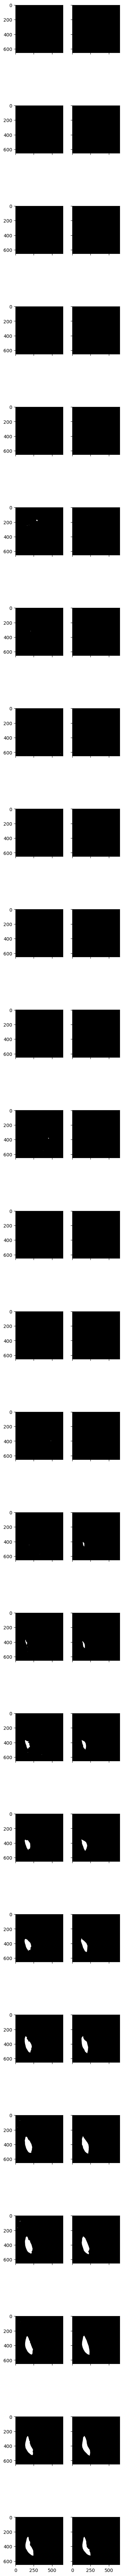

In [20]:
import torch
import torch.optim as optim
from torch import nn
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics import Dice
from skimage import io, transform
import sklearn.metrics as metrics
import numpy as np
import pathlib
import os

os.chdir("/content/drive/MyDrive/ML/FYP")

def save_volume(vol_in, vol_out, vol_pred, idx, meta):

	pathlib.Path(f"outputs/{idx}").mkdir(parents=True, exist_ok=True)
	pid = meta[0]
	metric_jacc = BinaryJaccardIndex()
	metric_dsc = Dice()

	for i, slice_ in enumerate(vol_in.detach().numpy()[0, 0, :, :, :], 1):	
		# binarize output
		# io.imsave(f'outputs/{idx}/{i}_in.jpg', slice_)
		# save label
		slice_ = vol_out.detach().numpy()[0, 0, i-1, :, :]
		slice_label = slice_
		slice_[slice_<0.5] = 0
		slice_[slice_>=0.5] = 1
		# io.imsave(f'outputs/{idx}/{i}_label.jpg', slice_)
		# save output
		slice_ = vol_pred.detach().numpy()[0, 0, i-1, :, :]
		slice_pred = slice_
		slice_[slice_<0.5] = 0
		slice_[slice_>=0.5] = 1
		# io.imsave(f'outputs/{idx}/{i}_out.jpg', slice_)

	fpr, tpr, threshold = metrics.roc_curve(
		vol_out.detach().numpy()[0, 0, :, :, :].flatten(), 
		vol_pred.detach().numpy()[0, 0, :, :, :].flatten()
	)
	roc_auc = metrics.auc(fpr, tpr)
	
	dsc = metric_dsc(
		vol_out.detach()[0, 0, :, :, :], 
		vol_pred.detach().long()[0, 0, :, :, :]
	)

	jaccard = metric_jacc(
		vol_out.detach()[0, 0, :, :, :], 
		vol_pred.detach()[0, 0, :, :, :]
	)

	print(f'{pid}\t{roc_auc}\t{dsc}\t{jaccard}')
		# if roc_auc>0.5:
		# 	# method I: plt
		# 	import matplotlib.pyplot as plt
		# 	plt.title('Receiver Operating Characteristic')
		# 	plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
		# 	plt.legend(loc = 'lower right')
		# 	plt.plot([0, 1], [0, 1],'r--')
		# 	plt.xlim([0, 1])
		# 	plt.ylim([0, 1])
		# 	plt.ylabel('True Positive Rate')
		# 	plt.xlabel('False Positive Rate')
		# 	plt.show()


def test_on_bhct():

	volume_path = os.path.join('assets', 'scan_6') 
	mask_path = os.path.join('assets', 'gt_6')

	# volume_path = os.path.join('assets', 'scan_071') 
	# mask_path = os.path.join('assets', 'gt_071')
 
	# volume_path = os.path.join('assets', 'scan_077') 
	# mask_path = os.path.join('assets', 'gt_077')
 
	# volume_path = os.path.join('assets', 'scan_097') 
	# mask_path = os.path.join('assets', 'gt_097')
 
	# volume_path = os.path.join('assets', 'scan_083') 
	# mask_path = os.path.join('assets', 'gt_083')

	def _load_volume():
    
		target_slice_size = None

		# TODO: This is a quick fix for sorting -- improve naming and sort logic
		slice_f_list = os.listdir(volume_path)
		slice_size = io.imread(os.path.join(volume_path, slice_f_list[0])).shape if target_slice_size is None else target_slice_size
		volume = np.zeros((len(slice_f_list), *slice_size))
		
		for slice_f in slice_f_list:
				try:
					slice_index = int(slice_f.split('_')[0])-1
				except: 
					slice_index = int(slice_f.split('.')[0])-1
				slice_ = io.imread(os.path.join(volume_path, slice_f))
				if target_slice_size is not None:
						slice_ = transform.resize(slice_, target_slice_size, order=0)
						# # make three-channel
						# slice_ = np.transpose(np.tile(slice_, (3, 1, 1)), (1, 2, 0))
				volume[slice_index, :, :] = slice_
		return [[volume]]

	def _load_mask():

			target_slice_size = None

			# TODO: This is a quick fix for sorting -- improve naming and sort logic
			slice_f_list = os.listdir(mask_path)
			slice_size = io.imread(os.path.join(mask_path, slice_f_list[0])).shape if target_slice_size is None else target_slice_size
			mask = np.zeros((len(slice_f_list), *slice_size))

			for slice_f in sorted(os.listdir(mask_path)):
					slice_index = int(slice_f.split('_')[0])-1
					slice_ = io.imread(os.path.join(mask_path, slice_f))
					if target_slice_size is not None:
							slice_ = transform.resize(slice_, target_slice_size, order=0)
					slice_[slice_<127] = 0
					slice_[slice_>=127] = 1
					mask[slice_index, :, :] = slice_
			return [[mask]]

	device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
	model = ProposedNet(1, 1, kn=(2, 2, 2, 2, 2), ds=True, FMU='sub').to(device)
	!ls
	model.load_state_dict(torch.load('temp_save.pth', map_location=torch.device('cpu')))
	model.eval()
	
	# data_sequencer = BHCTVolumeSequencer(BHCT_CSV_PATH, BHCT_DATA_PATH, 'test', with_meta=True)
	
	inputs = torch.Tensor(_load_volume()).to(device)
	outputs = model(inputs)
 
	print(outputs[0].shape)
	
	vol_pred = outputs[0].cpu()
	vol_out = torch.LongTensor(_load_mask()).to(device)
 
	metric_jacc = BinaryJaccardIndex()
	metric_dsc = Dice()

	fpr, tpr, threshold = metrics.roc_curve(
		vol_out.detach().numpy()[0, 0, :, :, :].flatten(), 
		vol_pred.detach().numpy()[0, 0, :, :, :].flatten()
	)
	roc_auc = metrics.auc(fpr, tpr)
	print("Area Under ROC:", roc_auc)
	
	dsc = metric_dsc(
		vol_pred.detach().long()[0, 0, :, :, :],
		vol_out.detach()[0, 0, :, :, :]
	)
	print("DSC:", dsc)

	# print(f'{pid}\t{roc_auc}\t{dsc}\t{jaccard}')
	from matplotlib import pyplot as plot

	print("Stitching output preview...")
	f, axarr = plot.subplots(26, 2, sharex=True, sharey=True, figsize=(4,100))
	vol_out = vol_out.detach().numpy()
	vol_pred = vol_pred.detach().numpy()
	vol_pred[vol_pred<0.5] = 0 
	vol_pred[vol_pred>=0.5] = 1
	for i in range(26):
		axarr[i,0].imshow(vol_pred[0, 0, i, :, :], cmap='gray')
		axarr[i,1].imshow(vol_out[0, 0, i, :, :], cmap='gray')
	plot.show()
 
	# for i, data in enumerate(data_sequencer, 1):
	# 	# get the inputs; data is a list of [inputs, labels]
	# 	inputs, labels, meta = data[0].to(device), data[1].to(device), data[2]
	# 	outputs = model(inputs)
		# print statistics
		# save_volume(inputs.cpu(), labels.cpu(), outputs[0].cpu(), i, meta)

test_on_bhct()